In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install imutils

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25836 sha256=592ad8c4f9d881f72c9cc72c60783cb0851229b853fe14f903dd750ed0ea1466
  Stored in directory: /home/ivan/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours


2022-11-03 09:56:23.539004: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 09:56:23.791472: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-03 09:56:23.801531: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ivan/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-11-03 09:56:23.801566: I te

In [5]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip
!unzip -qo data.zip


--2022-11-03 09:56:36--  https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.156.27
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.156.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28437489 (27M) [application/x-zip-compressed]
Saving to: ‘data.zip’

data.zip            100%[===================>]  27.12M   547KB/s    in 1m 53s  

2022-11-03 09:58:31 (246 KB/s) - ‘data.zip’ saved [28437489/28437489]



In [6]:
x = []
y = []
datadir = 'data/dataset'
for folder in os.listdir(datadir):
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)
        
print(len(x))
print(len(y))
print(f'labels : {list(set(y))}')


7600
7600
labels : ['2', 'div', '5', 'add', '7', 'sub', '9', '4', '8', 'mul', '1', '0', '6', '3']


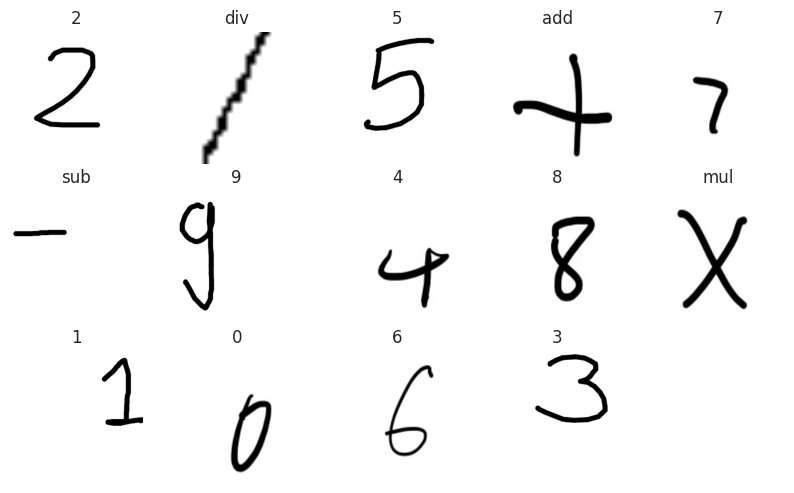

In [7]:
figure = plt.figure(figsize=(10, 10))
j = 0
for i in list(set(y)):
    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1


In [9]:
unique, count = np.unique(y, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(unique, count).set_title('Number of Images per Category')
plt.show()


TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 2000x1000 with 0 Axes>

In [10]:
X = []
for i in range(len(x)):
#     print(i)
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)
print(len(X))


7600


In [11]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(len(y))


7600


In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)


In [14]:
unique_train, count_train = np.unique(Y_train, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(unique_train, count_train).set_title('Number of Images per category in Train Set')
plt.show()


TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 2000x1000 with 0 Axes>

In [15]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(unique_test, count_test).set_title('Number of Images per category in Test Set')
plt.show()


TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 2000x1000 with 0 Axes>

In [16]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(6080, 32, 32, 1)
(1520, 32, 32, 1)
(6080, 14)
(1520, 14)


In [18]:
def math_symbol_and_digits_recognition(input_shape=(32, 32, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(14, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [19]:
model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))
model.summary()


2022-11-03 10:02:18.177852: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ivan/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-11-03 10:02:18.179303: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-03 10:02:18.179411: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ivan-Lenovo): /proc/driver/nvidia/version does not exist
2022-11-03 10:02:18.182010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        320       
                                                                 
 act1 (Activation)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 act2 (Activation)           (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                    

In [20]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('maths_symbol_and_digits_recognition.h5', 
                             monitor='val_loss', save_best_only=True, 
                             verbose=1, mode='min')

callbacks = [checkpoint, LearningRateScheduler(step_decay)]


In [23]:
aug = ImageDataGenerator(zoom_range=0.1,
#                          rotation_range=5,
                         width_shift_range=0.05,
                         height_shift_range=0.05)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=15, validation_data=(X_test, Y_test))
# hist2 = model2.fit(X_train, Y_train, batch_size=128, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)


Epoch 1/15
48/48 [==============================] - 3s 51ms/step - loss: 0.2662 - accuracy: 0.9439 - val_loss: 0.3164 - val_accuracy: 0.9599
Epoch 2/15
48/48 [==============================] - 3s 55ms/step - loss: 0.2812 - accuracy: 0.9395 - val_loss: 0.3663 - val_accuracy: 0.9434
Epoch 3/15
48/48 [==============================] - 3s 65ms/step - loss: 0.2499 - accuracy: 0.9485 - val_loss: 0.3111 - val_accuracy: 0.9572
Epoch 4/15
48/48 [==============================] - 3s 62ms/step - loss: 0.2519 - accuracy: 0.9475 - val_loss: 0.3033 - val_accuracy: 0.9586
Epoch 5/15
48/48 [==============================] - 3s 62ms/step - loss: 0.2414 - accuracy: 0.9503 - val_loss: 0.2712 - val_accuracy: 0.9592
Epoch 6/15
48/48 [==============================] - 3s 62ms/step - loss: 0.2516 - accuracy: 0.9482 - val_loss: 0.3705 - val_accuracy: 0.9408
Epoch 7/15
48/48 [==============================] - 3s 64ms/step - loss: 0.2371 - accuracy: 0.9551 - val_loss: 0.2586 - val_accuracy: 0.9645
Epoch 8/15
48

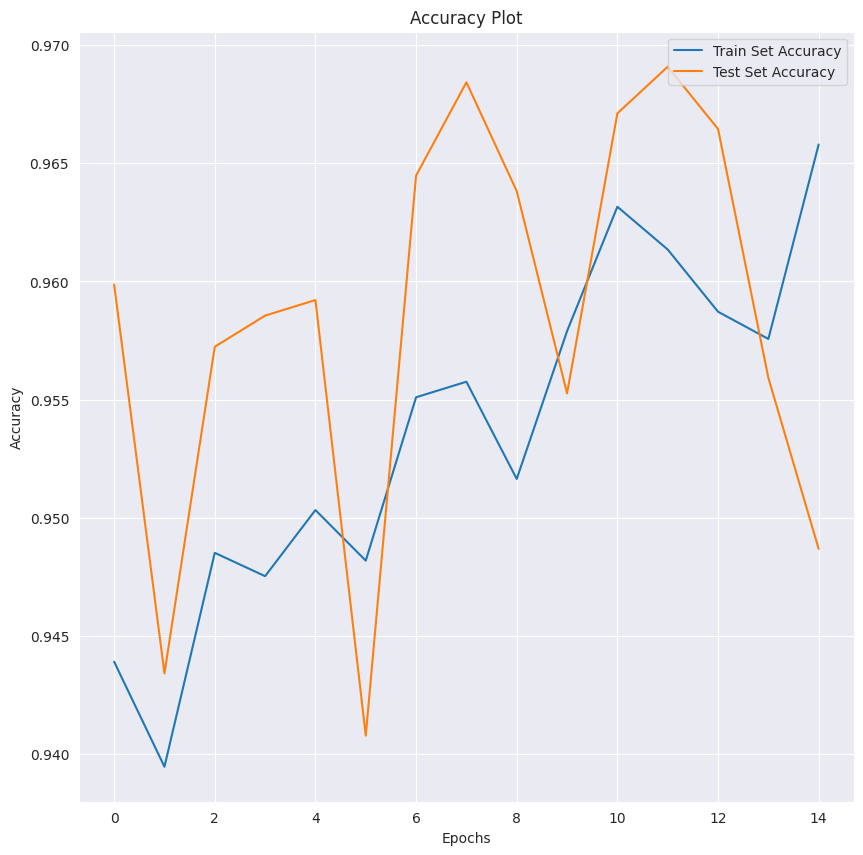

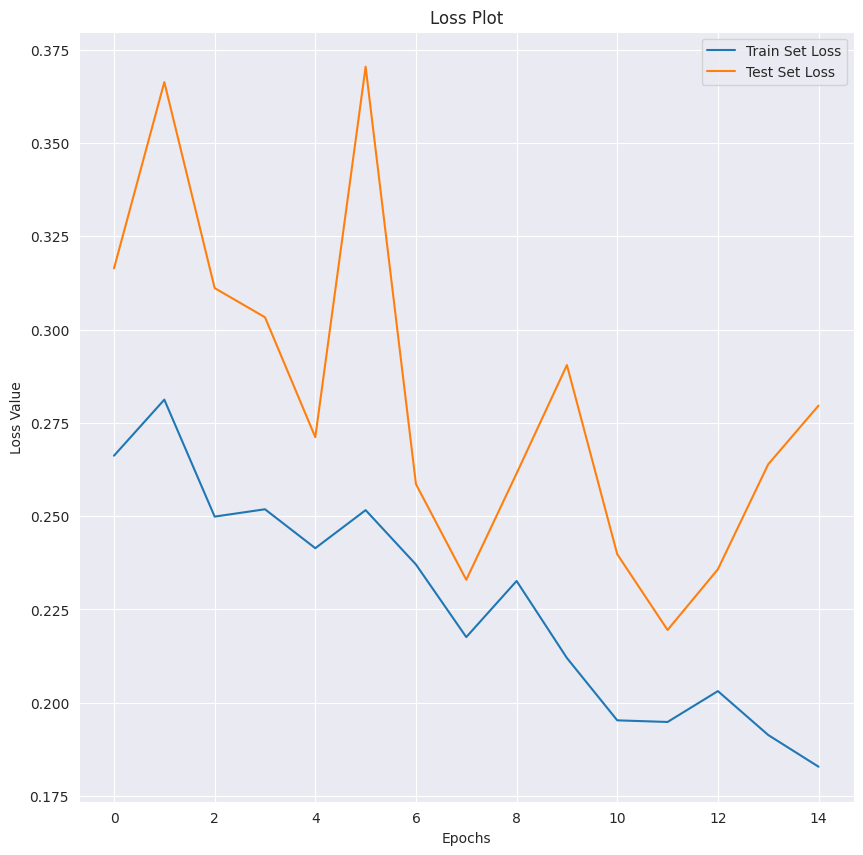

In [24]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()


In [25]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_hat, ypred))


48/48 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       114
           1       1.00      0.82      0.90       128
           2       0.94      0.96      0.95        85
           3       0.96      0.93      0.95       106
           4       0.92      0.90      0.91        93
           5       0.99      0.96      0.98        85
           6       0.95      0.93      0.94       122
           7       0.94      0.98      0.96        99
           8       0.82      0.95      0.88       117
           9       0.88      0.95      0.92       105
          10       0.99      0.95      0.97       128
          11       0.99      0.99      0.99       107
          12       0.98      0.99      0.98       122
          13       0.99      1.00      1.00       109

    accuracy                           0.95      1520
   macro avg       0.95      0.95      0.95      1520
weighted avg       0.95    

In [ ]:
model.save('model.h5')
